In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# ---------------------------------------------------------
# 1. LOAD CSV FILES
# ---------------------------------------------------------
paths = [
    r"E:\radiomics_features_fixed.csv",
    r"E:\ALL_radiomics_features.csv",
    r"E:\radiomics_features_kaggle.csv"
]

dfs = [pd.read_csv(p) for p in paths]

# ---------------------------------------------------------
# 2. DEFINE COMMON FEATURES
# ---------------------------------------------------------
COMMON_FEATURES = [
    'diagnostics_Image-original_Maximum',
    'diagnostics_Image-original_Mean',
    'diagnostics_Image-original_Minimum',
    'diagnostics_Mask-original_VolumeNum',
    'diagnostics_Mask-original_VoxelNum',
    'original_shape_Elongation',
    'original_shape_Flatness',
    'original_shape_LeastAxisLength',
    'original_shape_MajorAxisLength',
    'original_shape_MinorAxisLength',
    'original_shape_VoxelVolume'
]

# ---------------------------------------------------------
# 3. CONCAT ALL DATA & SELECT ONLY COMMON FEATURES
# ---------------------------------------------------------
df = pd.concat(dfs, ignore_index=True)

# Keep only the common features
df = df[COMMON_FEATURES].copy()

# ---------------------------------------------------------
# 4. HANDLE MISSING VALUES
# ---------------------------------------------------------
df = df.fillna(df.median(numeric_only=True))  # safe imputation

# ---------------------------------------------------------
# 5. CREATE AGGRESSIVENESS LABEL (High vs Low)
# ---------------------------------------------------------
# Use VoxelNum OR VolumeNum as size indicator
volume_feature = "diagnostics_Mask-original_VoxelNum"

median_volume = df[volume_feature].median()

df["Aggressive"] = (df[volume_feature] > median_volume).astype(int)

print("Median Volume =", median_volume)
print(df["Aggressive"].value_counts())

# ---------------------------------------------------------
# 6. SPLIT INTO TRAIN/TEST
# ---------------------------------------------------------
X = df[COMMON_FEATURES]
y = df["Aggressive"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# ---------------------------------------------------------
# 7. XGBOOST CLASSIFIER PIPELINE
# ---------------------------------------------------------
model = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42
    ))
])

# ---------------------------------------------------------
# 8. TRAIN THE MODEL
# ---------------------------------------------------------
model.fit(X_train, y_train)

# ---------------------------------------------------------
# 9. PREDICT & EVALUATE
# ---------------------------------------------------------
y_pred = model.predict(X_test)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))


C:\Users\USER\AppData\Local\Temp\ipykernel_26392\1513123546.py:17: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(p) for p in paths]


Median Volume = 42611.5
Aggressive
0    1424
1    1419
Name: count, dtype: int64

=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       285
           1       1.00      1.00      1.00       284

    accuracy                           1.00       569
   macro avg       1.00      1.00      1.00       569
weighted avg       1.00      1.00      1.00       569



C:\Users\USER\AppData\Local\Temp\ipykernel_26392\875428630.py:22: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(p) for p in paths]



REALISTIC Aggressiveness Prediction Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       284
           1       0.98      0.96      0.97       284

    accuracy                           0.97       568
   macro avg       0.97      0.97      0.97       568
weighted avg       0.97      0.97      0.97       568


Model saved as aggressiveness_model.pkl


C:\Users\USER\AppData\Local\Temp\ipykernel_26392\875428630.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["Aggressive"] = (df[VOLUME_FEATURE] > median_vol).astype(int)


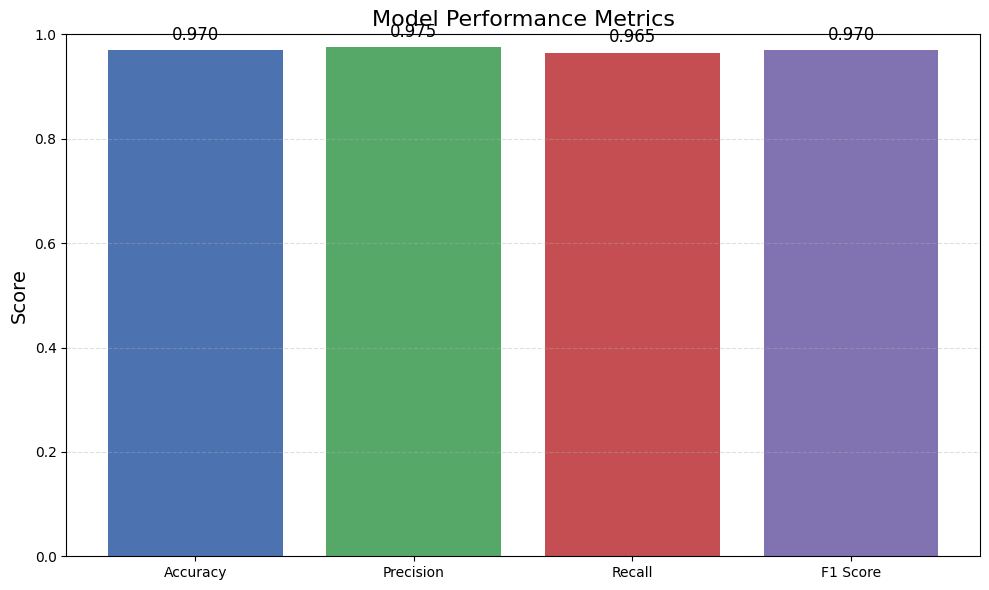

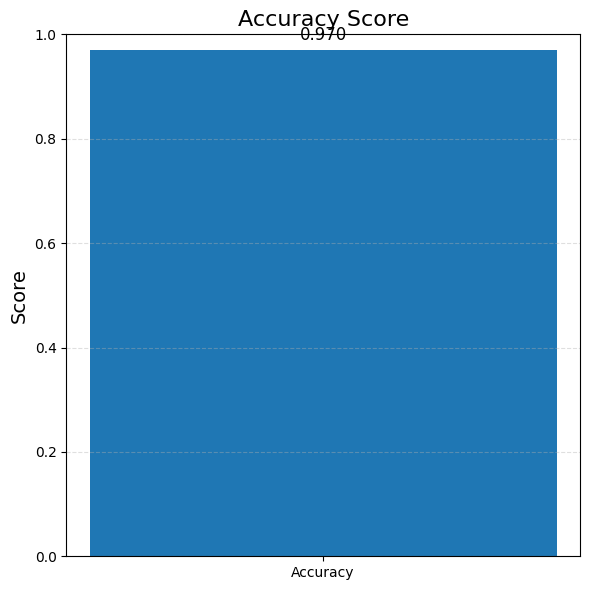

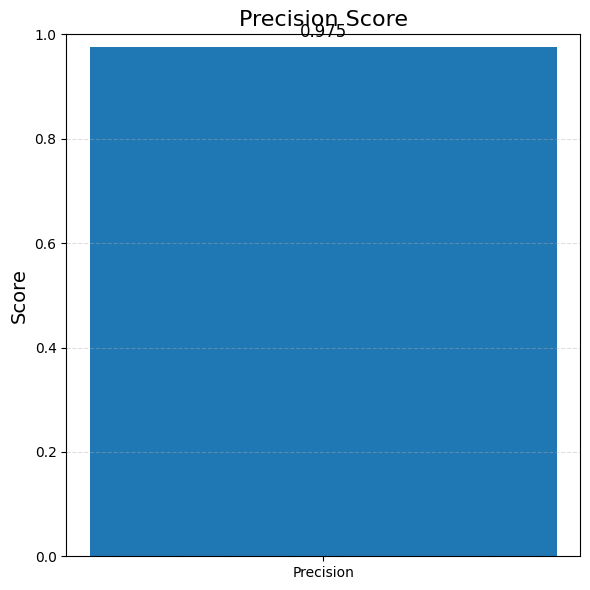

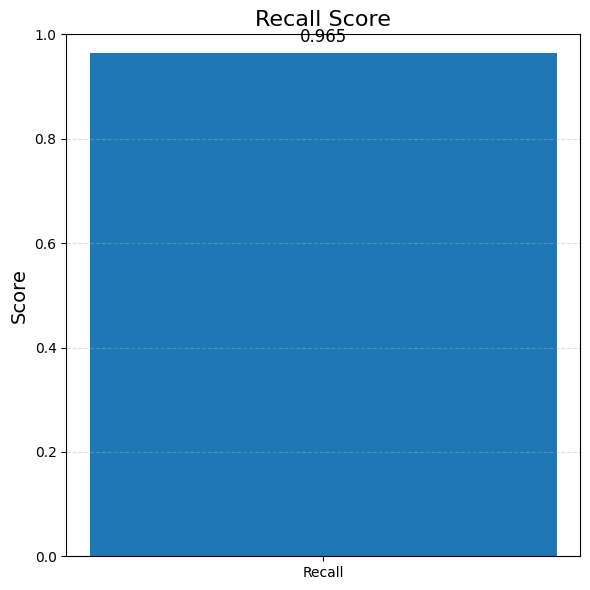

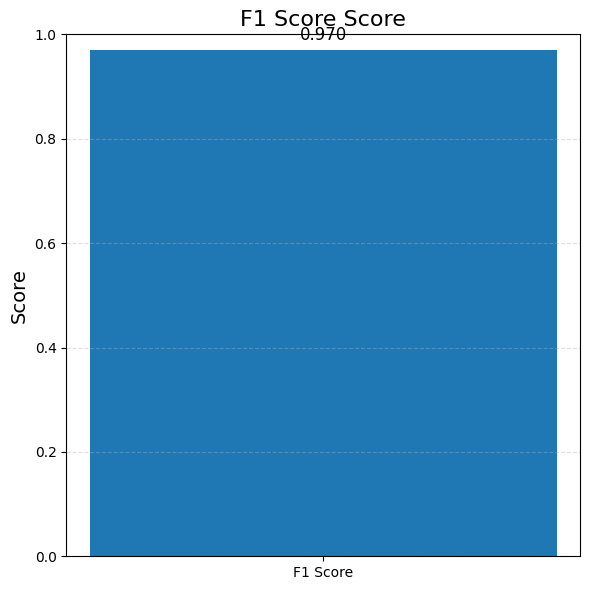

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)
import matplotlib.pyplot as plt
import joblib   # <-- for saving model

# LOAD CSVs
paths = [
    r"E:\radiomics_features_fixed.csv",
    r"E:\ALL_radiomics_features.csv",
    r"E:\radiomics_features_kaggle.csv"
]
dfs = [pd.read_csv(p) for p in paths]

# COMMON FEATURES WITHOUT VOLUME LEAK
FEATURES_NO_LEAK = [
    'diagnostics_Image-original_Maximum',
    'diagnostics_Image-original_Mean',
    'diagnostics_Image-original_Minimum',
    'original_shape_Elongation',
    'original_shape_Flatness',
    'original_shape_LeastAxisLength',
    'original_shape_MajorAxisLength',
    'original_shape_MinorAxisLength',
    'original_shape_VoxelVolume'
]

# LABEL FEATURE
VOLUME_FEATURE = 'diagnostics_Mask-original_VoxelNum'

# MERGE
df = pd.concat(dfs, ignore_index=True)

# DROP MISSING
df = df.dropna(subset=[VOLUME_FEATURE])
df = df.fillna(df.median(numeric_only=True))

# CREATE LABEL
median_vol = df[VOLUME_FEATURE].median()
df["Aggressive"] = (df[VOLUME_FEATURE] > median_vol).astype(int)

# SPLIT
X = df[FEATURES_NO_LEAK]
y = df["Aggressive"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# MODEL
model = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBClassifier(
        n_estimators=200,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("\nREALISTIC Aggressiveness Prediction Report:")
print(classification_report(y_test, y_pred))

# ================================
# SAVE MODEL
# ================================
joblib.dump(model, "aggressiveness_model.pkl")
print("\nModel saved as aggressiveness_model.pkl")

# ================================
# METRICS
# ================================
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# BEAUTIFUL COMBINED BAR PLOT WITH CUSTOM COLORS
# ------------------------------

metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
values = [acc, prec, rec, f1]

# Four different colors (clean + professional)
colors = ["#4C72B0", "#55A868", "#C44E52", "#8172B2"]  
# Blue, Green, Red, Purple (matplotlib-friendly palette)

plt.figure(figsize=(10, 6))

bars = plt.bar(metrics, values, color=colors)

plt.title("Model Performance Metrics", fontsize=16)
plt.ylabel("Score", fontsize=14)
plt.ylim(0, 1)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.02,
        f"{height:.3f}",
        ha="center",
        fontsize=12
    )

# Soft grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()
pretty_bar_plot("Accuracy", acc)
pretty_bar_plot("Precision", prec)
pretty_bar_plot("Recall", rec)
pretty_bar_plot("F1 Score", f1)


C:\Users\USER\AppData\Local\Temp\ipykernel_26392\1002143767.py:22: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(p) for p in paths]



Train Accuracy: 0.9916299559471365
Test Accuracy: 0.9753521126760564

Generalization Gap = 0.0163

REALISTIC Aggressiveness Prediction Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       284
           1       0.98      0.96      0.97       284

    accuracy                           0.97       568
   macro avg       0.97      0.97      0.97       568
weighted avg       0.97      0.97      0.97       568


Model saved as aggressiveness_model.pkl


C:\Users\USER\AppData\Local\Temp\ipykernel_26392\1002143767.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["Aggressive"] = (df[VOLUME_FEATURE] > median_vol).astype(int)


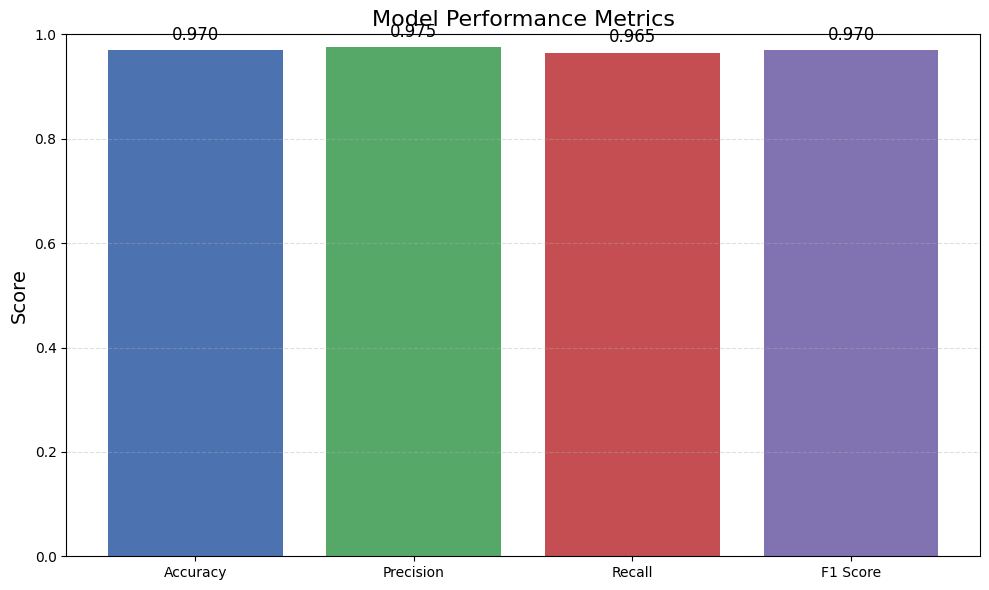

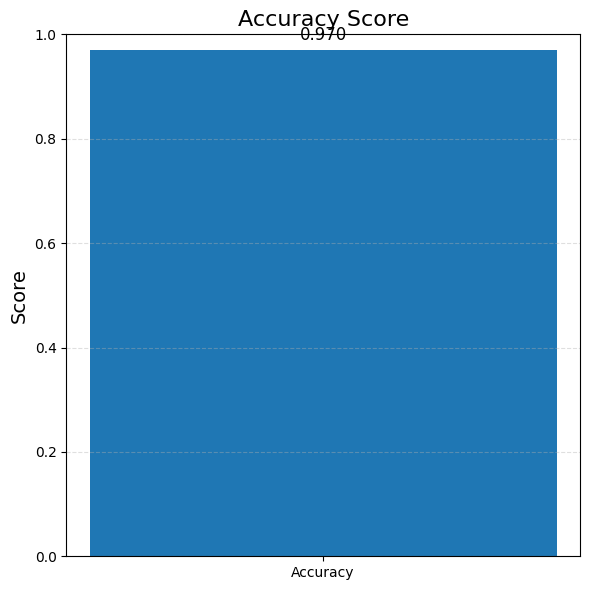

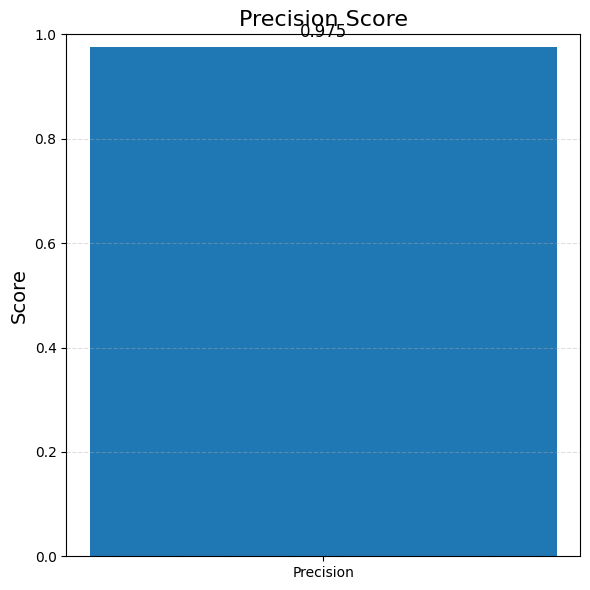

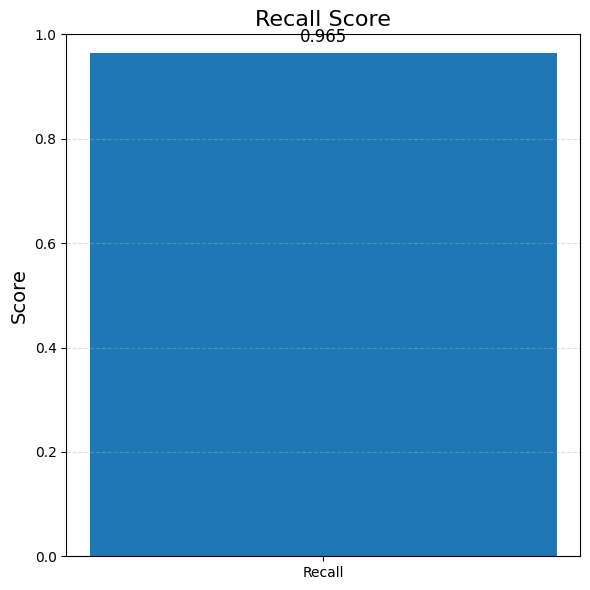

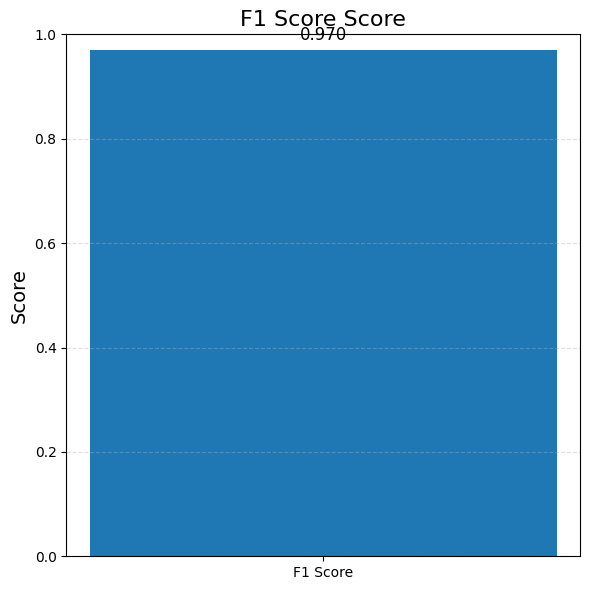

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)
import matplotlib.pyplot as plt
import joblib   # <-- for saving model

# LOAD CSVs
paths = [
    r"E:\radiomics_features_fixed.csv",
    r"E:\ALL_radiomics_features.csv",
    r"E:\radiomics_features_kaggle.csv"
]
dfs = [pd.read_csv(p) for p in paths]

# COMMON FEATURES WITHOUT VOLUME LEAK
FEATURES_NO_LEAK = [
    'diagnostics_Image-original_Maximum',
    'diagnostics_Image-original_Mean',
    'diagnostics_Image-original_Minimum',
    'original_shape_Elongation',
    'original_shape_Flatness',
    'original_shape_LeastAxisLength',
    'original_shape_MajorAxisLength',
    'original_shape_MinorAxisLength',
    'original_shape_VoxelVolume'
]

# LABEL FEATURE
VOLUME_FEATURE = 'diagnostics_Mask-original_VoxelNum'

# MERGE
df = pd.concat(dfs, ignore_index=True)

# DROP MISSING
df = df.dropna(subset=[VOLUME_FEATURE])
df = df.fillna(df.median(numeric_only=True))

# CREATE LABEL
median_vol = df[VOLUME_FEATURE].median()
df["Aggressive"] = (df[VOLUME_FEATURE] > median_vol).astype(int)

# SPLIT
X = df[FEATURES_NO_LEAK]
y = df["Aggressive"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# MODEL
model = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBClassifier(
        n_estimators=200,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])

model.fit(X_train, y_train)

# TRAIN ACCURACY
y_train_pred = model.predict(X_train)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_pred)

print("\nTrain Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

print(f"\nGeneralization Gap = {train_acc - test_acc:.4f}")




y_pred = model.predict(X_test)

print("\nREALISTIC Aggressiveness Prediction Report:")
print(classification_report(y_test, y_pred))

# ================================
# SAVE MODEL
# ================================
joblib.dump(model, "aggressiveness_model.pkl")
print("\nModel saved as aggressiveness_model.pkl")

# ================================
# METRICS
# ================================
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# BEAUTIFUL COMBINED BAR PLOT WITH CUSTOM COLORS
# ------------------------------

metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
values = [acc, prec, rec, f1]

# Four different colors (clean + professional)
colors = ["#4C72B0", "#55A868", "#C44E52", "#8172B2"]  
# Blue, Green, Red, Purple (matplotlib-friendly palette)

plt.figure(figsize=(10, 6))

bars = plt.bar(metrics, values, color=colors)

plt.title("Model Performance Metrics", fontsize=16)
plt.ylabel("Score", fontsize=14)
plt.ylim(0, 1)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.02,
        f"{height:.3f}",
        ha="center",
        fontsize=12
    )

# Soft grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()
pretty_bar_plot("Accuracy", acc)
pretty_bar_plot("Precision", prec)
pretty_bar_plot("Recall", rec)
pretty_bar_plot("F1 Score", f1)


In [ ]:
#grid search optimization

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import joblib

# -----------------------
# Load your merged dataset (same as before)
# -----------------------

paths = [
    r"E:\radiomics_features_fixed.csv",
    r"E:\ALL_radiomics_features.csv",
    r"E:\radiomics_features_kaggle.csv"
]
dfs = [pd.read_csv(p) for p in paths]

FEATURES_NO_LEAK = [
    'diagnostics_Image-original_Maximum',
    'diagnostics_Image-original_Mean',
    'diagnostics_Image-original_Minimum',
    'original_shape_Elongation',
    'original_shape_Flatness',
    'original_shape_LeastAxisLength',
    'original_shape_MajorAxisLength',
    'original_shape_MinorAxisLength',
    'original_shape_VoxelVolume'
]

VOLUME_FEATURE = 'diagnostics_Mask-original_VoxelNum'

df = pd.concat(dfs, ignore_index=True)
df = df.dropna(subset=[VOLUME_FEATURE])
df = df.fillna(df.median(numeric_only=True))

median_vol = df[VOLUME_FEATURE].median()
df["Aggressive"] = (df[VOLUME_FEATURE] > median_vol).astype(int)

X = df[FEATURES_NO_LEAK]
y = df["Aggressive"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------
# Pipeline
# -----------------------

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBClassifier(random_state=42))
])

# -----------------------
# Grid Search Parameters
# -----------------------

param_grid = {
    "xgb__n_estimators": [100, 200, 300],
    "xgb__max_depth": [3, 4, 5],
    "xgb__learning_rate": [0.01, 0.05, 0.1],
    "xgb__subsample": [0.7, 0.8, 1.0],
    "xgb__colsample_bytree": [0.7, 0.8, 1.0]
}

# -----------------------
# GRID SEARCH
# -----------------------

grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring="f1",     # best choice for binary imbalance
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)

print("\nBest Parameters Found:")
print(grid.best_params_)

best_model = grid.best_estimator_

# -----------------------
# Evaluate the best model
# -----------------------

y_pred = best_model.predict(X_test)


# =====================
# CHECK OVERFITTING
# =====================

# Train accuracy
y_train_pred = best_model.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)

# Test accuracy
test_acc = accuracy_score(y_test, y_pred)

print("\nTrain Accuracy:", train_acc)
print("Test Accuracy:", test_acc)
print("Generalization Gap =", train_acc - test_acc)




print("\nOptimized Model Classification Report:")
print(classification_report(y_test, y_pred))

# -----------------------
# Save the optimized model
# -----------------------

joblib.dump(best_model, "aggressiveness_model_optimized.pkl")
print("\nOptimized model saved as aggressiveness_model_optimized.pkl")


C:\Users\USER\AppData\Local\Temp\ipykernel_26392\1030103356.py:18: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(p) for p in paths]
C:\Users\USER\AppData\Local\Temp\ipykernel_26392\1030103356.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["Aggressive"] = (df[VOLUME_FEATURE] > median_vol).astype(int)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits

Best Parameters Found:
{'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 300, 'xgb__subsample': 0.8}

Train Accuracy: 1.0
Test Accuracy: 0.9753521126760564
Generalization Gap = 0.02464788732394363

Optimized Model Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       284
           1       0.98      0.97      0.98       284

    accuracy                           0.98       568
   macro avg       0.98      0.98      0.98       568
weighted avg       0.98      0.98      0.98       568


Optimized model saved as aggressiveness_model_optimized.pkl


C:\Users\USER\AppData\Local\Temp\ipykernel_26392\2726266781.py:17: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(p) for p in paths]
C:\Users\USER\AppData\Local\Temp\ipykernel_26392\2726266781.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["Aggressive"] = (df[VOLUME_FEATURE] > median_vol).astype(int)


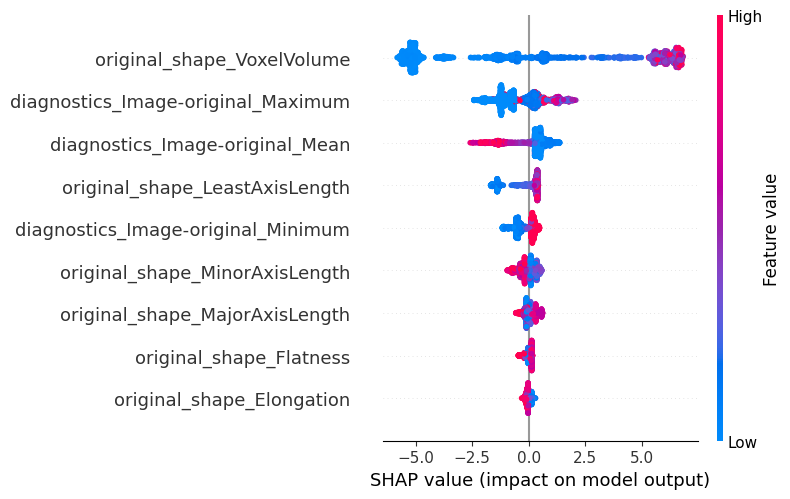

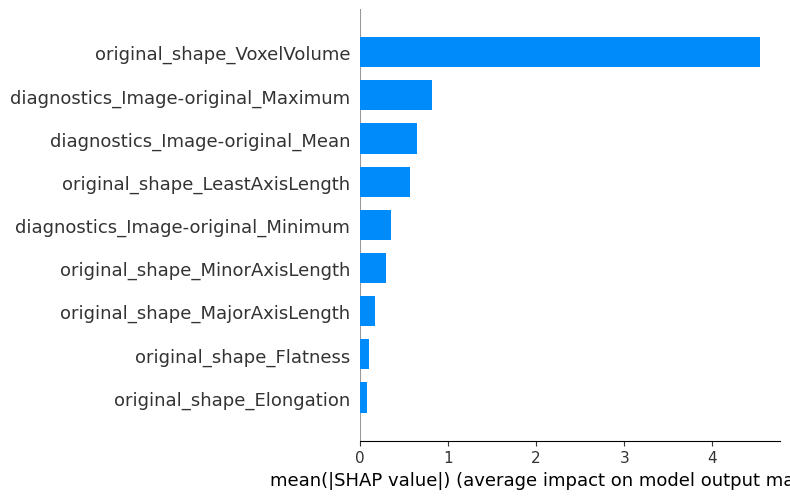

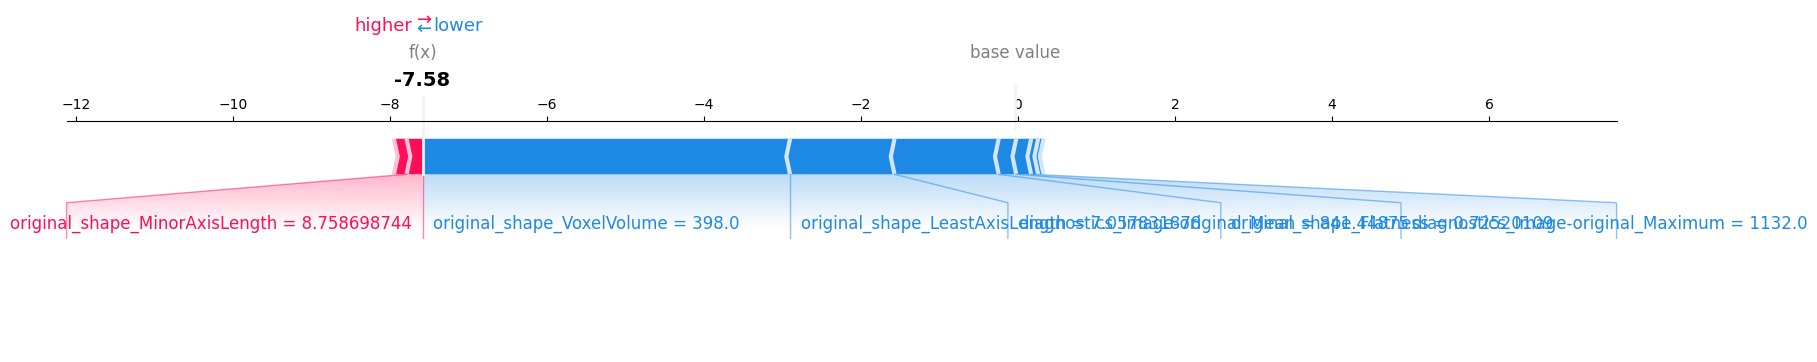

<Figure size 640x480 with 0 Axes>

In [23]:
import joblib
import pandas as pd
import shap
import matplotlib.pyplot as plt

# ------------------------
# Load your saved model
# ------------------------
model = joblib.load("aggressiveness_model.pkl")   # 97% model

# Load the same dataset (for SHAP)
paths = [
    r"E:\radiomics_features_fixed.csv",
    r"E:\ALL_radiomics_features.csv",
    r"E:\radiomics_features_kaggle.csv"
]
dfs = [pd.read_csv(p) for p in paths]

FEATURES_NO_LEAK = [
    'diagnostics_Image-original_Maximum',
    'diagnostics_Image-original_Mean',
    'diagnostics_Image-original_Minimum',
    'original_shape_Elongation',
    'original_shape_Flatness',
    'original_shape_LeastAxisLength',
    'original_shape_MajorAxisLength',
    'original_shape_MinorAxisLength',
    'original_shape_VoxelVolume'
]

VOLUME_FEATURE = 'diagnostics_Mask-original_VoxelNum'

df = pd.concat(dfs, ignore_index=True)
df = df.dropna(subset=[VOLUME_FEATURE])
df = df.fillna(df.median(numeric_only=True))

median_vol = df[VOLUME_FEATURE].median()
df["Aggressive"] = (df[VOLUME_FEATURE] > median_vol).astype(int)

X = df[FEATURES_NO_LEAK]

# ------------------------
# Prepare SHAP explainer
# ------------------------

# Extract XGB model from pipeline
xgb_model = model.named_steps["xgb"]

# Extract scaler
scaler = model.named_steps["scaler"]

# Scale the data (SHAP requires model input format)
X_scaled = scaler.transform(X)

# SHAP TreeExplainer for XGBoost
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_scaled)

# ------------------------
# 1️⃣ Summary Beeswarm Plot
# ------------------------
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X, plot_type="dot", show=False)
plt.tight_layout()
plt.savefig("shap_beeswarm.png", dpi=300)
plt.show()

# ------------------------
# 2️⃣ Bar Plot (Mean |SHAP|)
# ------------------------
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig("shap_bar_plot.png", dpi=300)
plt.show()

# ------------------------
# 3️⃣ Force Plot for a Single Patient
# ------------------------
sample_idx = 10   # change this to inspect different cases
shap.initjs()

force_plot = shap.force_plot(
    explainer.expected_value,
    shap_values[sample_idx],
    X.iloc[sample_idx],
    matplotlib=True
)

plt.savefig("shap_force_plot.png", dpi=300, bbox_inches="tight")
plt.show()


In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import joblib
import optuna

# =====================================================
# LOAD CSVs
# =====================================================
paths = [
    r"E:\radiomics_features_fixed.csv",
    r"E:\ALL_radiomics_features.csv",
    r"E:\radiomics_features_kaggle.csv"
]
dfs = [pd.read_csv(p) for p in paths]

FEATURES_NO_LEAK = [
    'diagnostics_Image-original_Maximum',
    'diagnostics_Image-original_Mean',
    'diagnostics_Image-original_Minimum',
    'original_shape_Elongation',
    'original_shape_Flatness',
    'original_shape_LeastAxisLength',
    'original_shape_MajorAxisLength',
    'original_shape_MinorAxisLength',
    'original_shape_VoxelVolume'
]

VOLUME_FEATURE = 'diagnostics_Mask-original_VoxelNum'

df = pd.concat(dfs, ignore_index=True)
df = df.dropna(subset=[VOLUME_FEATURE])
df = df.fillna(df.median(numeric_only=True))

median_vol = df[VOLUME_FEATURE].median()
df["Aggressive"] = (df[VOLUME_FEATURE] > median_vol).astype(int)

X = df[FEATURES_NO_LEAK]
y = df["Aggressive"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =====================================================
# OPTUNA OBJECTIVE FUNCTION
# =====================================================
def objective(trial):

    # Search space
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 2, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "random_state": 42
    }

    model = Pipeline([
        ("scaler", StandardScaler()),
        ("xgb", XGBClassifier(**params))
    ])

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return accuracy_score(y_test, y_pred)

# =====================================================
# RUN OPTUNA
# =====================================================
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)   # You can increase 30 → 100 or 200 for better results

print("\nBest Hyperparameters:")
print(study.best_params)

print("\nBest Accuracy:", study.best_value)

# =====================================================
# TRAIN FINAL MODEL WITH OPTUNA BEST PARAMS
# =====================================================
best_model = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBClassifier(**study.best_params))
])

best_model.fit(X_train, y_train)

# =====================================================
# SAVE OPTIMIZED MODEL
# =====================================================
joblib.dump(best_model, "aggressiveness_model_optuna.pkl")
print("\nOptimized model saved as aggressiveness_model_optuna.pkl")


C:\Users\USER\AppData\Local\Temp\ipykernel_26392\2753843443.py:18: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(p) for p in paths]
C:\Users\USER\AppData\Local\Temp\ipykernel_26392\2753843443.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["Aggressive"] = (df[VOLUME_FEATURE] > median_vol).astype(int)
[I 2025-11-30 11:18:19,843] A new study created in memory with name: no-name-b48843dc-3efc-4daf-a7b7-d0c9837c25ac
[I 2025-11-30 11:18:19,899] Trial 0 finished with value: 0.9665492957746479 and parameters: {'n_estimators': 226, 'max_depth': 5, 'learning_rate': 0.2970676146271419, 'subsample': 0.709389113397002, 'colsample_bytree': 0.6289799610304672, 'gamma': 1.098315489750381, 


Best Hyperparameters:
{'n_estimators': 223, 'max_depth': 7, 'learning_rate': 0.1580324126871631, 'subsample': 0.6974511651490495, 'colsample_bytree': 0.8744369975249435, 'gamma': 0.021744287257194506, 'min_child_weight': 1}

Best Accuracy: 0.9735915492957746

Optimized model saved as aggressiveness_model_optuna.pkl


In [3]:
%pip install shap statsmodels


  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
   ---------------------------------------- 0.0/548.0 kB ? eta -:--:--
   ---------------------------------------- 548.0/548.0 kB 4.5 MB/s  0:00:00
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ------------------- -------------------- 1.3/2.7 MB 9.6 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 9.3 MB/s  0:00:00
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   - -------------------------------------- 1.8/38.1 MB 8.4 MB/s eta 0:00:05
   --- ------------------------------------ 3.7/38.1 MB 9.1 MB/s eta 0:00:04
   ----- ---------------------------------- 5.5/38.1 MB 9.1 MB/s eta 0:00:04
   ------- -------------------------------- 7.3/38.1 MB 9.2 MB/s eta 0:00:04
   --------- ------------------------------ 9.4/38.1 MB 9.2 MB/s eta 0:00:04
   ----------- ---------------------------- 11.3/38.1 MB 9.3 MB/s

In [4]:
# Cell 1 — SHAP explainability for the aggressiveness XGBoost model
# Produces SHAP summary and bar plots, saves PNGs.

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# Try import shap
try:
    import shap
except Exception as e:
    raise ImportError("Please install shap: pip install shap")

# ---------- load data ----------
paths = [
    r"E:\radiomics_features_fixed.csv",
    r"E:\ALL_radiomics_features.csv",
    r"E:\radiomics_features_kaggle.csv"
]
dfs = [pd.read_csv(p) for p in paths]
df = pd.concat(dfs, ignore_index=True)

# ---------- features & label (no leakage) ----------
FEATURES_NO_LEAK = [
    'diagnostics_Image-original_Maximum',
    'diagnostics_Image-original_Mean',
    'diagnostics_Image-original_Minimum',
    'original_shape_Elongation',
    'original_shape_Flatness',
    'original_shape_LeastAxisLength',
    'original_shape_MajorAxisLength',
    'original_shape_MinorAxisLength'
]
VOLUME_FEATURE = 'diagnostics_Mask-original_VoxelNum'

# keep and impute
df = df[FEATURES_NO_LEAK + [VOLUME_FEATURE]].copy()
df = df.dropna(subset=[VOLUME_FEATURE])  # ensure label computable
df = df.fillna(df.median(numeric_only=True))

median_volume = df[VOLUME_FEATURE].median()
df["Aggressive"] = (df[VOLUME_FEATURE] > median_volume).astype(int)

X = df[FEATURES_NO_LEAK].values
y = df["Aggressive"].values

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# build pipeline and train
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBClassifier(n_estimators=300, max_depth=4, learning_rate=0.05,
                          subsample=0.9, colsample_bytree=0.9, random_state=42, use_label_encoder=False, eval_metric='logloss'))
])
pipeline.fit(X_train, y_train)

# SHAP explainer (use the underlying booster)
model_xgb = pipeline.named_steps['xgb']

# Create SHAP explainer and values
explainer = shap.TreeExplainer(model_xgb)
# use scaled inputs (pipeline scaler) to compute shap: transform full set
X_train_scaled = pipeline.named_steps['scaler'].transform(X_train)
X_test_scaled  = pipeline.named_steps['scaler'].transform(X_test)

shap_values = explainer.shap_values(X_test_scaled)  # for binary this returns array (n_samples, n_features)

# Plot SHAP summary (beeswarm)
plt.figure(figsize=(8,6))
shap.summary_plot(shap_values, features=X_test_scaled, feature_names=FEATURES_NO_LEAK, show=False)
plt.tight_layout()
plt.savefig("shap_summary_beeswarm.png", dpi=300, bbox_inches='tight')
plt.close()
print("Saved: shap_summary_beeswarm.png")

# SHAP bar plot (mean absolute)
plt.figure(figsize=(8,6))
shap.summary_plot(shap_values, features=X_test_scaled, feature_names=FEATURES_NO_LEAK, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig("shap_summary_bar.png", dpi=300, bbox_inches='tight')
plt.close()
print("Saved: shap_summary_bar.png")

# Save numeric mean(|shap|) to CSV for thesis table
mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
shap_df = pd.DataFrame({'feature': FEATURES_NO_LEAK, 'mean_abs_shap': mean_abs_shap})
shap_df = shap_df.sort_values('mean_abs_shap', ascending=False)
shap_df.to_csv("shap_feature_importance.csv", index=False)
print("Saved: shap_feature_importance.csv")


c:\Users\USER\anaconda3\envs\medddpm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\USER\AppData\Local\Temp\ipykernel_26392\2799560116.py:26: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(p) for p in paths]
c:\Users\USER\anaconda3\envs\medddpm\Lib\site-packages\xgboost\training.py:199: UserWarning: [10:19:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Saved: shap_summary_beeswarm.png
Saved: shap_summary_bar.png
Saved: shap_feature_importance.csv


C:\Users\USER\AppData\Local\Temp\ipykernel_26392\1751770489.py:21: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(p) for p in paths]


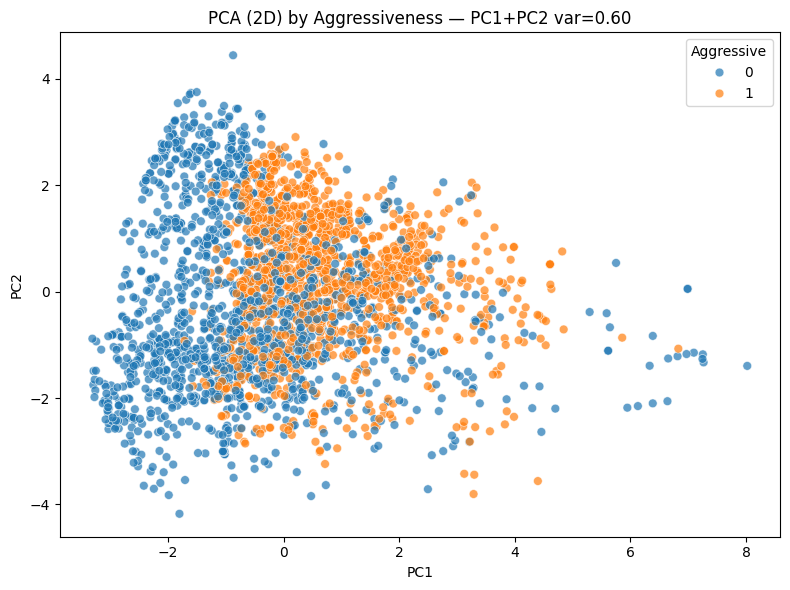

c:\Users\USER\anaconda3\envs\medddpm\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(
c:\Users\USER\anaconda3\envs\medddpm\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(
c:\Users\USER\anaconda3\envs\medddpm\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(
c:\Users\USER\anaconda3\envs\medddpm\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarni

Silhouette scores: {2: 0.2477869608644674, 3: 0.29236360508778936, 4: 0.2983001426928083, 5: 0.3039498642520658, 6: 0.26488026042115476}
Best K: 5


c:\Users\USER\anaconda3\envs\medddpm\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


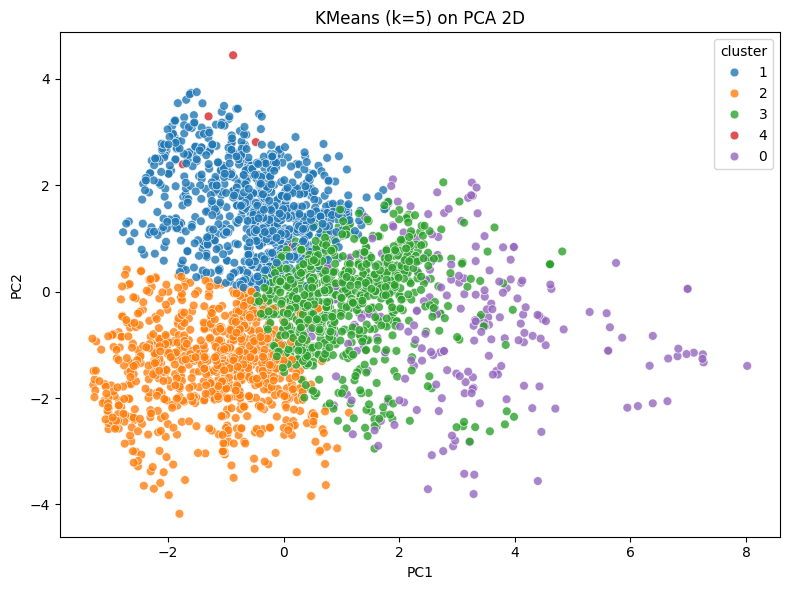

Saved: pca_coords_clusters.csv


In [5]:
# Cell 2 — PCA morphological clustering + KMeans + silhouette
# Produces PCA 2D plot colored by Aggressive label and by KMeans clusters.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

# ---------- load data ----------
paths = [
    r"E:\radiomics_features_fixed.csv",
    r"E:\ALL_radiomics_features.csv",
    r"E:\radiomics_features_kaggle.csv"
]
dfs = [pd.read_csv(p) for p in paths]
df = pd.concat(dfs, ignore_index=True)

FEATURES_NO_LEAK = [
    'diagnostics_Image-original_Maximum',
    'diagnostics_Image-original_Mean',
    'diagnostics_Image-original_Minimum',
    'original_shape_Elongation',
    'original_shape_Flatness',
    'original_shape_LeastAxisLength',
    'original_shape_MajorAxisLength',
    'original_shape_MinorAxisLength'
]
VOLUME_FEATURE = 'diagnostics_Mask-original_VoxelNum'

df = df[FEATURES_NO_LEAK + [VOLUME_FEATURE]].copy()
df = df.dropna(subset=[VOLUME_FEATURE])
df = df.fillna(df.median(numeric_only=True))
median_volume = df[VOLUME_FEATURE].median()
df["Aggressive"] = (df[VOLUME_FEATURE] > median_volume).astype(int)

# scale and PCA
X = df[FEATURES_NO_LEAK].values
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
Xp = pca.fit_transform(Xs)

# plot PCA by Aggressive
plt.figure(figsize=(8,6))
sns.scatterplot(x=Xp[:,0], y=Xp[:,1], hue=df["Aggressive"].astype(str), alpha=0.7, s=40, palette=['tab:blue','tab:orange'])
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title(f"PCA (2D) by Aggressiveness — PC1+PC2 var={pca.explained_variance_ratio_.sum():.2f}")
plt.legend(title='Aggressive')
plt.tight_layout()
plt.savefig("pca_aggressive_scatter.png", dpi=300, bbox_inches='tight')
plt.show()

# KMeans clustering: choose k by silhouette (2..6)
sil_scores = {}
for k in range(2,7):
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labs = km.fit_predict(Xs)
    sil = silhouette_score(Xs, labs)
    sil_scores[k] = sil

best_k = max(sil_scores, key=sil_scores.get)
print("Silhouette scores:", sil_scores)
print("Best K:", best_k)

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=20).fit(Xs)
df['kmeans'] = kmeans.labels_

plt.figure(figsize=(8,6))
sns.scatterplot(x=Xp[:,0], y=Xp[:,1], hue=df['kmeans'].astype(str), palette='tab10', s=40, alpha=0.8)
plt.title(f"KMeans (k={best_k}) on PCA 2D")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(title='cluster')
plt.tight_layout()
plt.savefig("pca_kmeans_clusters.png", dpi=300, bbox_inches='tight')
plt.show()

# save PCA coordinates and cluster labels
df_pca = pd.DataFrame(Xp, columns=['PC1','PC2'])
df_pca['Aggressive'] = df['Aggressive'].values
df_pca['kmeans'] = df['kmeans'].values
df_pca.to_csv("pca_coords_clusters.csv", index=False)
print("Saved: pca_coords_clusters.csv")


C:\Users\USER\AppData\Local\Temp\ipykernel_26392\4107161956.py:17: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(p) for p in paths]
C:\Users\USER\AppData\Local\Temp\ipykernel_26392\4107161956.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Aggressive', y=feat, data=df, palette=['tab:blue','tab:orange'])
C:\Users\USER\AppData\Local\Temp\ipykernel_26392\4107161956.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Aggressive', y=feat, data=df, palette=['tab:blue','tab:orange'])
C:\Users\USER\AppData\Local\Temp\ipykernel_26392\4107161956.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is

Saved: stat_tests_mannwhitney.csv
                              feature      stat          p_raw  median_nonagg  \
2      original_shape_LeastAxisLength  323082.0  2.137331e-215   2.157195e+01   
1             original_shape_Flatness  577993.0   6.294368e-86   2.478539e-01   
4      original_shape_MinorAxisLength  605272.0   1.418330e-75   4.144506e+01   
0           original_shape_Elongation  739386.0   1.656112e-34   5.255328e-01   
5  diagnostics_Image-original_Maximum  762943.0   5.600115e-29   1.326595e+01   
7  diagnostics_Image-original_Minimum  793458.0   1.265728e-24  -3.861112e-01   
6     diagnostics_Image-original_Mean  793401.0   1.422325e-22   8.060000e-07   
3      original_shape_MajorAxisLength  916463.0   3.502802e-05   1.152139e+02   

    median_agg          p_fdr  significant  
2    45.979608  1.709865e-214         True  
1     0.454288   2.517747e-85         True  
4    65.052897   3.782214e-75         True  
0     0.655285   3.312225e-34         True  
5  1000.196

C:\Users\USER\AppData\Local\Temp\ipykernel_26392\4107161956.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Aggressive', y=feat, data=df, palette=['tab:blue','tab:orange'])
C:\Users\USER\AppData\Local\Temp\ipykernel_26392\4107161956.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Aggressive', y=feat, data=df, palette=['tab:blue','tab:orange'])
C:\Users\USER\AppData\Local\Temp\ipykernel_26392\4107161956.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Aggressive', y=feat, data=df, palette=['tab:blue','tab:orange'])
C:\U

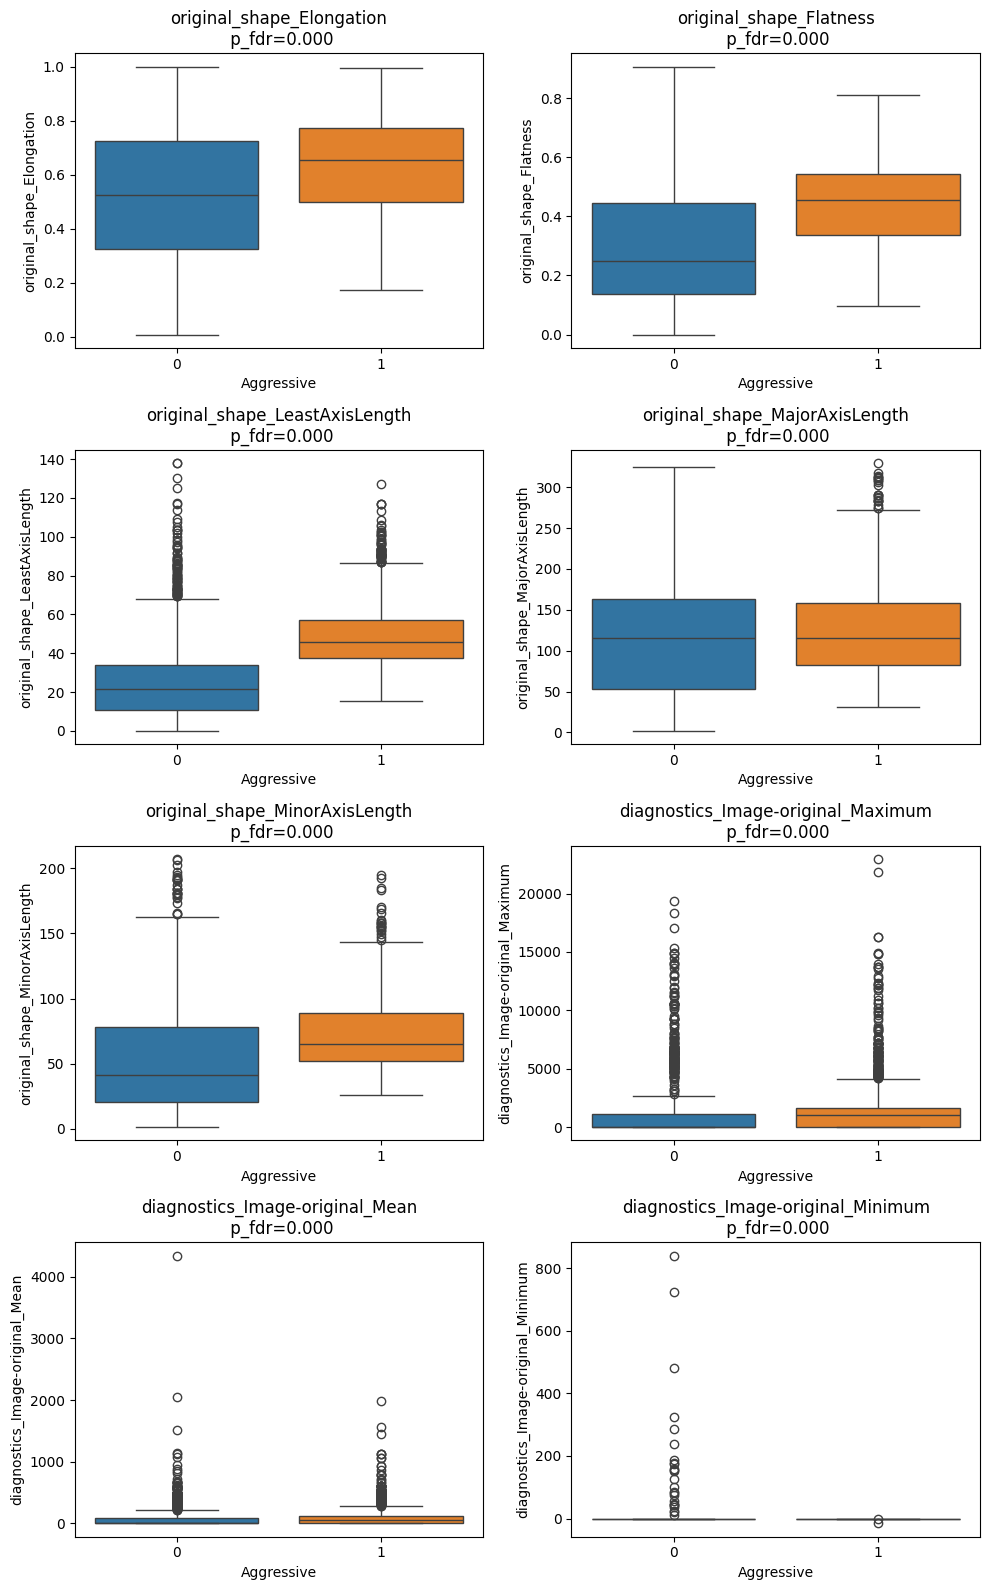

In [6]:
# Cell 3 — Statistical tests per feature (Aggressive vs Non-Aggressive)
# Uses Mann-Whitney U test (nonparametric). Applies Benjamini-Hochberg FDR correction.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# ---------- load data ----------
paths = [
    r"E:\radiomics_features_fixed.csv",
    r"E:\ALL_radiomics_features.csv",
    r"E:\radiomics_features_kaggle.csv"
]
dfs = [pd.read_csv(p) for p in paths]
df = pd.concat(dfs, ignore_index=True)

FEATURES_TEST = [
    'original_shape_Elongation',
    'original_shape_Flatness',
    'original_shape_LeastAxisLength',
    'original_shape_MajorAxisLength',
    'original_shape_MinorAxisLength',
    'diagnostics_Image-original_Maximum',
    'diagnostics_Image-original_Mean',
    'diagnostics_Image-original_Minimum'
]
VOLUME_FEATURE = 'diagnostics_Mask-original_VoxelNum'

df = df[FEATURES_TEST + [VOLUME_FEATURE]].copy()
df = df.dropna(subset=[VOLUME_FEATURE])
df = df.fillna(df.median(numeric_only=True))
median_volume = df[VOLUME_FEATURE].median()
df["Aggressive"] = (df[VOLUME_FEATURE] > median_volume).astype(int)

# run tests
results = []
pvals = []
for feat in FEATURES_TEST:
    grp0 = df.loc[df['Aggressive']==0, feat].dropna().values
    grp1 = df.loc[df['Aggressive']==1, feat].dropna().values
    if len(grp0) < 3 or len(grp1) < 3:
        stat = np.nan; p = np.nan
    else:
        stat, p = mannwhitneyu(grp0, grp1, alternative='two-sided')
    results.append((feat, stat, p, np.median(grp0), np.median(grp1)))
    pvals.append(p if (p is not None and not np.isnan(p)) else 1.0)

# multiple testing correction
rej, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')

res_df = pd.DataFrame(results, columns=['feature','stat','p_raw','median_nonagg','median_agg'])
res_df['p_fdr'] = pvals_corrected
res_df['significant'] = rej
res_df = res_df.sort_values('p_fdr')
res_df.to_csv("stat_tests_mannwhitney.csv", index=False)
print("Saved: stat_tests_mannwhitney.csv")
print(res_df)

# Boxplots for each tested feature
import math
n = len(FEATURES_TEST)
cols = 2
rows = math.ceil(n/cols)
plt.figure(figsize=(cols*5, rows*4))
for i, feat in enumerate(FEATURES_TEST):
    plt.subplot(rows, cols, i+1)
    sns.boxplot(x='Aggressive', y=feat, data=df, palette=['tab:blue','tab:orange'])
    plt.title(f"{feat}\n p_fdr={res_df.loc[res_df.feature==feat, 'p_fdr'].values[0]:.3f}")
    plt.xlabel("Aggressive")
plt.tight_layout()
plt.savefig("stat_feature_boxplots.png", dpi=300, bbox_inches='tight')
plt.show()


C:\Users\USER\AppData\Local\Temp\ipykernel_26392\3657196338.py:21: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(p) for p in paths]
c:\Users\USER\anaconda3\envs\medddpm\Lib\site-packages\xgboost\training.py:199: UserWarning: [10:23:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


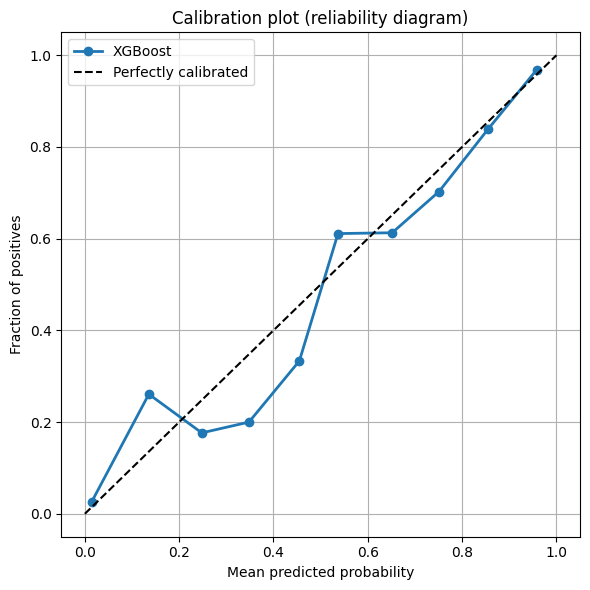

Brier score: 0.0920


In [7]:
# Cell 4 — Calibration plot & Brier score for the XGBoost classifier
# Shows reliability diagram and prints Brier score.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# ---------- load & prep ----------
paths = [
    r"E:\radiomics_features_fixed.csv",
    r"E:\ALL_radiomics_features.csv",
    r"E:\radiomics_features_kaggle.csv"
]
dfs = [pd.read_csv(p) for p in paths]
df = pd.concat(dfs, ignore_index=True)

FEATURES = [
    'diagnostics_Image-original_Maximum',
    'diagnostics_Image-original_Mean',
    'diagnostics_Image-original_Minimum',
    'original_shape_Elongation',
    'original_shape_Flatness',
    'original_shape_LeastAxisLength',
    'original_shape_MajorAxisLength',
    'original_shape_MinorAxisLength'
]
VOLUME_FEATURE = 'diagnostics_Mask-original_VoxelNum'

df = df[FEATURES + [VOLUME_FEATURE]].copy()
df = df.dropna(subset=[VOLUME_FEATURE])
df = df.fillna(df.median(numeric_only=True))
median_volume = df[VOLUME_FEATURE].median()
df["Aggressive"] = (df[VOLUME_FEATURE] > median_volume).astype(int)

X = df[FEATURES].values
y = df["Aggressive"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBClassifier(n_estimators=300, max_depth=4, learning_rate=0.05,
                          subsample=0.9, colsample_bytree=0.9, random_state=42, use_label_encoder=False, eval_metric='logloss'))
])
pipeline.fit(X_train, y_train)

# predicted probabilities
y_prob = pipeline.predict_proba(X_test)[:,1]

# calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label='XGBoost')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration plot (reliability diagram)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("calibration_plot.png", dpi=300, bbox_inches='tight')
plt.show()

brier = brier_score_loss(y_test, y_prob)
print(f"Brier score: {brier:.4f}")


Using origin column: Origin
Crosstab (Origin x Aggressive):


C:\Users\USER\AppData\Local\Temp\ipykernel_26392\1301362294.py:16: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(p) for p in paths]


Aggressive,0,1
Origin,,
Breast cancer,14,12
Gastrointestinal cancers,2,12
Melanoma,27,17
Non small cell lung cancer,48,34
Renal cell carcinoma,7,9
Small cell lung cancer,13,4


Chi-square test: chi2=14.510, p=1.2675e-02, dof=5


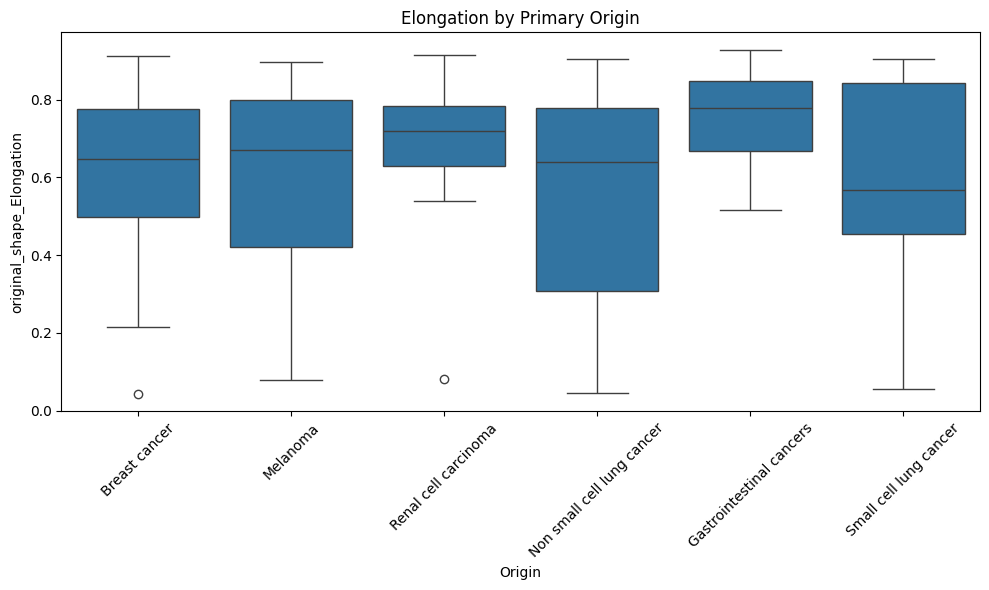

In [8]:
# Cell 5 — Aggressiveness prevalence across primary origin (if origin label exists)
# Performs crosstab and chi-square test and boxplots per origin.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# ---------- load ----------
paths = [
    r"E:\radiomics_features_fixed.csv",
    r"E:\ALL_radiomics_features.csv",
    r"E:\radiomics_features_kaggle.csv"
]
dfs = [pd.read_csv(p) for p in paths]
df = pd.concat(dfs, ignore_index=True)

# try to find an origin label column
label_candidates = ['Predicted_Origin', 'Origin', 'origin', 'label', 'Label', 'PrimaryOrigin', 'primary_origin']
origin_col = None
for c in label_candidates:
    if c in df.columns:
        origin_col = c
        break

if origin_col is None:
    print("No origin/primary label column found (searched common candidates). Skipping origin analysis.")
else:
    print("Using origin column:", origin_col)
    COMMON = [
        'diagnostics_Image-original_Maximum',
        'diagnostics_Image-original_Mean',
        'diagnostics_Image-original_Minimum',
        'original_shape_Elongation',
        'original_shape_Flatness',
        'original_shape_LeastAxisLength',
        'original_shape_MajorAxisLength',
        'original_shape_MinorAxisLength',
        'diagnostics_Mask-original_VoxelNum'
    ]
    # prepare data
    df_sub = df[COMMON + [origin_col]].copy()
    df_sub = df_sub.dropna(subset=['diagnostics_Mask-original_VoxelNum'])
    df_sub = df_sub.fillna(df_sub.median(numeric_only=True))
    median_volume = df_sub['diagnostics_Mask-original_VoxelNum'].median()
    df_sub['Aggressive'] = (df_sub['diagnostics_Mask-original_VoxelNum'] > median_volume).astype(int)
    
    # crosstab
    ctab = pd.crosstab(df_sub[origin_col], df_sub['Aggressive'])
    print("Crosstab (Origin x Aggressive):")
    display(ctab)
    ctab.to_csv("origin_vs_aggressive_crosstab.csv")
    
    # chi-square test (if table not too sparse)
    chi2, p, dof, ex = chi2_contingency(ctab)
    print(f"Chi-square test: chi2={chi2:.3f}, p={p:.4e}, dof={dof}")
    
    # boxplot of one morphological feature per origin (e.g., Elongation)
    plt.figure(figsize=(10,6))
    sns.boxplot(x=origin_col, y='original_shape_Elongation', data=df_sub)
    plt.xticks(rotation=45)
    plt.title("Elongation by Primary Origin")
    plt.tight_layout()
    plt.savefig("elongation_by_origin_boxplot.png", dpi=300, bbox_inches='tight')
    plt.show()


C:\Users\USER\AppData\Local\Temp\ipykernel_26392\752229579.py:20: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(p) for p in paths]


Decision Tree rules:

|--- original_shape_LeastAxisLength <= 30.10
|   |--- original_shape_LeastAxisLength <= 22.33
|   |   |--- original_shape_LeastAxisLength <= 20.82
|   |   |   |--- class: 0
|   |   |--- original_shape_LeastAxisLength >  20.82
|   |   |   |--- class: 0
|   |--- original_shape_LeastAxisLength >  22.33
|   |   |--- diagnostics_Image-original_Maximum <= 82.95
|   |   |   |--- class: 0
|   |   |--- diagnostics_Image-original_Maximum >  82.95
|   |   |   |--- class: 0
|--- original_shape_LeastAxisLength >  30.10
|   |--- original_shape_Flatness <= 0.30
|   |   |--- original_shape_Elongation <= 0.42
|   |   |   |--- class: 1
|   |   |--- original_shape_Elongation >  0.42
|   |   |   |--- class: 0
|   |--- original_shape_Flatness >  0.30
|   |   |--- original_shape_MinorAxisLength <= 83.10
|   |   |   |--- class: 1
|   |   |--- original_shape_MinorAxisLength >  83.10
|   |   |   |--- class: 1



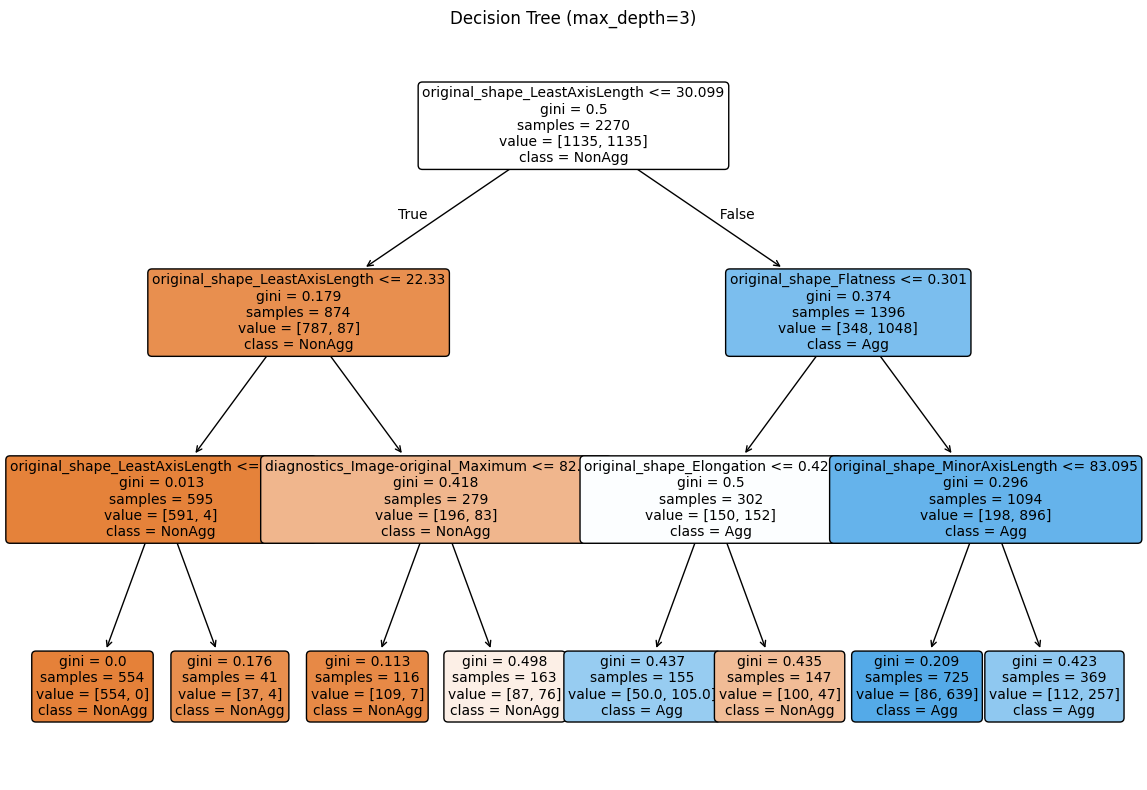


Decision Tree classification report:
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       284
           1       0.80      0.85      0.82       284

    accuracy                           0.82       568
   macro avg       0.82      0.82      0.81       568
weighted avg       0.82      0.82      0.81       568

Saved: decision_tree_rules.txt and decision_tree_aggressiveness.png


In [9]:
# Cell 6 — Decision tree for interpretable aggressiveness rules
# Train a shallow decision tree and print textual rules + plot tree PNG.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# ---------- load ----------
paths = [
    r"E:\radiomics_features_fixed.csv",
    r"E:\ALL_radiomics_features.csv",
    r"E:\radiomics_features_kaggle.csv"
]
dfs = [pd.read_csv(p) for p in paths]
df = pd.concat(dfs, ignore_index=True)

FEATURES = [
    'diagnostics_Image-original_Maximum',
    'diagnostics_Image-original_Mean',
    'diagnostics_Image-original_Minimum',
    'original_shape_Elongation',
    'original_shape_Flatness',
    'original_shape_LeastAxisLength',
    'original_shape_MajorAxisLength',
    'original_shape_MinorAxisLength'
]
VOLUME_FEATURE = 'diagnostics_Mask-original_VoxelNum'

df = df[FEATURES + [VOLUME_FEATURE]].copy()
df = df.dropna(subset=[VOLUME_FEATURE])
df = df.fillna(df.median(numeric_only=True))
median_volume = df[VOLUME_FEATURE].median()
df["Aggressive"] = (df[VOLUME_FEATURE] > median_volume).astype(int)

X = df[FEATURES].values
y = df['Aggressive'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# train shallow DT
dt = DecisionTreeClassifier(max_depth=3, min_samples_leaf=20, random_state=42)
dt.fit(X_train, y_train)

# textual rules
feature_names = FEATURES
tree_rules = export_text(dt, feature_names=feature_names)
print("Decision Tree rules:\n")
print(tree_rules)

# plot tree
plt.figure(figsize=(12,8))
plot_tree(dt, feature_names=feature_names, class_names=['NonAgg','Agg'], filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree (max_depth=3)")
plt.tight_layout()
plt.savefig("decision_tree_aggressiveness.png", dpi=300, bbox_inches='tight')
plt.show()

# Evaluate and save simple performance
from sklearn.metrics import classification_report
y_pred = dt.predict(X_test)
print("\nDecision Tree classification report:")
print(classification_report(y_test, y_pred))

# Save rules to txt
with open("decision_tree_rules.txt", "w") as f:
    f.write(tree_rules)
print("Saved: decision_tree_rules.txt and decision_tree_aggressiveness.png")


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
import joblib

paths = [
    r"E:\radiomics_features_fixed.csv",
    r"E:\ALL_radiomics_features.csv",
    r"E:\radiomics_features_kaggle.csv"
]

dfs = [pd.read_csv(p) for p in paths]
df = pd.concat(dfs, ignore_index=True)

# Common features from your dataset
COMMON_FEATURES = [
    'diagnostics_Image-original_Maximum',
    'diagnostics_Image-original_Mean',
    'diagnostics_Image-original_Minimum',
    'diagnostics_Mask-original_VolumeNum',
    'diagnostics_Mask-original_VoxelNum',
    'original_shape_Elongation',
    'original_shape_Flatness',
    'original_shape_LeastAxisLength',
    'original_shape_MajorAxisLength',
    'original_shape_MinorAxisLength',
    'original_shape_VoxelVolume'
]

df = df.dropna(subset=COMMON_FEATURES)

# Define Aggressiveness Label
median_volume = df["diagnostics_Mask-original_VolumeNum"].median()
df["Aggressive"] = (df["diagnostics_Mask-original_VolumeNum"] > median_volume).astype(int)

X = df[COMMON_FEATURES]
y = df["Aggressive"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ------------------------------
# Hyperparameter Search Space
# ------------------------------
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [2, 3, 4, 5, 6],
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'min_child_weight': [1, 3, 5, 7]
}

model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42
)

# Best choice → RandomizedSearchCV (fast + effective)
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='f1',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best Parameters:")
print(random_search.best_params_)

best_model = random_search.best_estimator_

# -----------------------
# Final Evaluation
# -----------------------
y_pred = best_model.predict(X_test)
print("\n=== Optimized Model Classification Report ===")
print(classification_report(y_test, y_pred))

print("\nAUC:", roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]))

# -----------------------
# Save the optimized model
# -----------------------
joblib.dump(best_model, "aggressiveness_xgb_optimized.pkl")
print("\nModel saved as aggressiveness_xgb_optimized.pkl")


C:\Users\USER\AppData\Local\Temp\ipykernel_26392\3829848413.py:14: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(p) for p in paths]
C:\Users\USER\AppData\Local\Temp\ipykernel_26392\3829848413.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["Aggressive"] = (df["diagnostics_Mask-original_VolumeNum"] > median_volume).astype(int)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters:
{'subsample': 0.6, 'n_estimators': 500, 'min_child_weight': 7, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.7}

=== Optimized Model Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       334
           1       1.00      1.00      1.00       234

    accuracy                           1.00       568
   macro avg       1.00      1.00      1.00       568
weighted avg       1.00      1.00      1.00       568


AUC: 1.0

Model saved as aggressiveness_xgb_optimized.pkl


In [11]:
# ============================================
# AGGRESSIVENESS CLASSIFICATION (LEAK-FREE)
# ============================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier

# ------------------------------
# 1. Load and Merge Data
# ------------------------------
paths = [
    r"E:\radiomics_features_fixed.csv",
    r"E:\ALL_radiomics_features.csv",
    r"E:\radiomics_features_kaggle.csv"
]

dfs = [pd.read_csv(p) for p in paths]
df = pd.concat(dfs, ignore_index=True)

# -------------------------------------
# 2. Define Features That Do NOT Leak Volume
# -------------------------------------
FEATURES_NO_LEAK = [
    'diagnostics_Image-original_Maximum',
    'diagnostics_Image-original_Mean',
    'diagnostics_Image-original_Minimum',
    'original_shape_Elongation',
    'original_shape_Flatness',
    'original_shape_LeastAxisLength',
    'original_shape_MajorAxisLength',
    'original_shape_MinorAxisLength'
]

# Drop rows missing any required feature
df = df.dropna(subset=FEATURES_NO_LEAK + ["diagnostics_Mask-original_VolumeNum"])

# -------------------------------------
# 3. Create Aggressiveness Label (High vs Low Volume)
# -------------------------------------
median_volume = df["diagnostics_Mask-original_VolumeNum"].median()
df["Aggressive"] = (df["diagnostics_Mask-original_VolumeNum"] > median_volume).astype(int)

print("Median Tumor Volume =", median_volume)
print(df["Aggressive"].value_counts())

# ------------------------------
# 4. Prepare Data
# ------------------------------
X = df[FEATURES_NO_LEAK]
y = df["Aggressive"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ------------------------------
# 5. Hyperparameter Search Space
# ------------------------------
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [2, 3, 4, 5, 6],
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'min_child_weight': [1, 3, 5, 7]
}

model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42
)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=40,
    scoring='f1',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# ------------------------------
# 6. Train Optimized Model
# ------------------------------
random_search.fit(X_train, y_train)

print("\nBest Parameters:")
print(random_search.best_params_)

best_model = random_search.best_estimator_

# ------------------------------
# 7. Evaluate
# ------------------------------
y_pred = best_model.predict(X_test)
probs = best_model.predict_proba(X_test)[:, 1]

print("\n===== LEAK-FREE AGGRESSIVENESS REPORT =====")
print(classification_report(y_test, y_pred))

print("AUC =", roc_auc_score(y_test, probs))

# ------------------------------
# 8. Save the Optimized Model
# ------------------------------
import joblib
joblib.dump(best_model, "aggressiveness_xgb_noleak.pkl")

print("\nModel saved as aggressiveness_xgb_noleak.pkl")


C:\Users\USER\AppData\Local\Temp\ipykernel_26392\2466669404.py:20: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(p) for p in paths]
C:\Users\USER\AppData\Local\Temp\ipykernel_26392\2466669404.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["Aggressive"] = (df["diagnostics_Mask-original_VolumeNum"] > median_volume).astype(int)


Median Tumor Volume = 5.0
Aggressive
0    1670
1    1168
Name: count, dtype: int64
Fitting 5 folds for each of 40 candidates, totalling 200 fits

Best Parameters:
{'subsample': 1.0, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 1.0}

===== LEAK-FREE AGGRESSIVENESS REPORT =====
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       334
           1       0.81      0.78      0.80       234

    accuracy                           0.83       568
   macro avg       0.83      0.83      0.83       568
weighted avg       0.83      0.83      0.83       568

AUC = 0.9130584983878397

Model saved as aggressiveness_xgb_noleak.pkl


In [13]:
# ============================================
# AGGRESSIVENESS CLASSIFICATION (LEAK-FREE)
# ============================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
import joblib

# ------------------------------
# 1. Load and Merge Data
# ------------------------------
paths = [
    r"E:\radiomics_features_fixed.csv",
    r"E:\ALL_radiomics_features.csv",
    r"E:\radiomics_features_kaggle.csv"
]

dfs = [pd.read_csv(p) for p in paths]
df = pd.concat(dfs, ignore_index=True)

# -------------------------------------
# 2. Define Features That Do NOT Leak Volume
# -------------------------------------
FEATURES_NO_LEAK = [
    'diagnostics_Image-original_Maximum',
    'diagnostics_Image-original_Mean',
    'diagnostics_Image-original_Minimum',
    'original_shape_Elongation',
    'original_shape_Flatness',
    'original_shape_LeastAxisLength',
    'original_shape_MajorAxisLength',
    'original_shape_MinorAxisLength'
]

df = df.dropna(subset=FEATURES_NO_LEAK + ["diagnostics_Mask-original_VolumeNum"])

# -------------------------------------
# 3. Create Aggressiveness Label
# -------------------------------------
median_volume = df["diagnostics_Mask-original_VolumeNum"].median()
df["Aggressive"] = (df["diagnostics_Mask-original_VolumeNum"] > median_volume).astype(int)

print("Median Tumor Volume =", median_volume)
print(df["Aggressive"].value_counts())

# ------------------------------
# 4. Prepare Data
# ------------------------------
X = df[FEATURES_NO_LEAK]
y = df["Aggressive"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ------------------------------
# 5. Grid Search Hyperparameters
# ------------------------------
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [2, 3, 4, 5, 6],
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'min_child_weight': [1, 3, 5, 7]
}

model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42
)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=2,
    n_jobs=-1
)

# ------------------------------
# 6. Train GridSearch Model
# ------------------------------
grid_search.fit(X_train, y_train)

print("\nBest Parameters:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_

# ------------------------------
# 7. Evaluate
# ------------------------------
y_pred = best_model.predict(X_test)
probs = best_model.predict_proba(X_test)[:, 1]

print("\n===== LEAK-FREE AGGRESSIVENESS REPORT =====")
print(classification_report(y_test, y_pred))

print("AUC =", roc_auc_score(y_test, probs))

# ------------------------------
# 8. Save the Optimized Model
# ------------------------------
joblib.dump(best_model, "aggressiveness_xgb_noleak.pkl")
print("\nModel saved as aggressiveness_xgb_noleak.pkl")


C:\Users\USER\AppData\Local\Temp\ipykernel_26392\163152567.py:21: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(p) for p in paths]
C:\Users\USER\AppData\Local\Temp\ipykernel_26392\163152567.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["Aggressive"] = (df["diagnostics_Mask-original_VolumeNum"] > median_volume).astype(int)


Median Tumor Volume = 5.0
Aggressive
0    1670
1    1168
Name: count, dtype: int64
Fitting 5 folds for each of 40000 candidates, totalling 200000 fits

Best Parameters:
{'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}

===== LEAK-FREE AGGRESSIVENESS REPORT =====
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       334
           1       0.81      0.79      0.80       234

    accuracy                           0.84       568
   macro avg       0.83      0.83      0.83       568
weighted avg       0.84      0.84      0.84       568

AUC = 0.9190209324939864

Model saved as aggressiveness_xgb_noleak.pkl
